# NLP Code

## Overview

 TED talks have been inspiring people since 1987 when it was founded by Richard Saulman as non-profit organization. Gathering speakers and experts from different fields such as technology, history, art, entertainment, and designs to share their ideas and thoughts for the public. Operating under the theme “ideas worth spreading”, TED talks videos and audio data are available online, uploaded in TED official website ever since it was first filmed in 1994.

 In this project, we will be analyzing the dataset using machine learning algorithms to find the most inspiring topics and talks among the 2,550 talks.


In [89]:
!pip install pandas-profiling
!pip install textblob
!pip install pyspellchecker

In [90]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import string
import re
from time import time
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import stats
from pandas.io.json import json_normalize
from pandas_profiling import ProfileReport
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from spellchecker import SpellChecker


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hayataldhahri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hayataldhahri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [91]:
ted_talk = pd.read_csv(r"Dataset/ted_main.csv")
ted_talk.head()

comments                                        description  duration  \
0      4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1       265  With the same humor and humanity he exuded in ...       977   
2       124  New York Times columnist David Pogue takes aim...      1286   
3       200  In an emotionally charged talk, MacArthur-winn...      1116   
4       593  You've never seen data presented like this. Wi...      1190   

     event   film_date  languages   main_speaker  \
0  TED2006  1140825600         60   Ken Robinson   
1  TED2006  1140825600         43        Al Gore   
2  TED2006  1140739200         26    David Pogue   
3  TED2006  1140912000         35  Majora Carter   
4  TED2006  1140566400         48   Hans Rosling   

                                            name  num_speaker  published_date  \
0      Ken Robinson: Do schools kill creativity?            1      1151367060   
1           Al Gore: Averting the climate crisis            1      1151367060   
2                  David Pogue: Simplicity sells            1      1151367060   
3             Majora Carter: Greening the ghetto            1      1151367060   
4  Hans Rosling: The best stats you've ever seen            1      1151440680   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   

                                       related_talks  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1  [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2  [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3  [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4  [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   

                     speaker_occupation  \
0                       Author/educator   
1                      Climate advocate   
2                  Technology columnist   
3    Activist for environmental justice   
4  Global health expert; data visionary   

                                                tags  \
0  ['children', 'creativity', 'culture', 'dance',...   
1  ['alternative energy', 'cars', 'climate change...   
2  ['computers', 'entertainment', 'interface desi...   
3  ['MacArthur grant', 'activism', 'business', 'c...   
4  ['Africa', 'Asia', 'Google', 'demo', 'economic...   

                             title  \
0      Do schools kill creativity?   
1      Averting the climate crisis   
2                 Simplicity sells   
3              Greening the ghetto   
4  The best stats you've ever seen   

                                                 url     views  
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  
1  https://www.ted.com/talks/al_gore_on_averting_...   3200520  
2  https://www.ted.com/talks/david_pogue_says_sim...   1636292  
3  https://www.ted.com/talks/majora_carter_s_tale...   1697550  
4  https://www.ted.com/talks/hans_rosling_shows_t...  12005869

In [92]:
transcripts = pd.read_csv(r"Dataset/transcripts.csv")
transcripts.head()

transcript  \
0  Good morning. How are you?(Laughter)It's been ...   
1  Thank you so much, Chris. And it's truly a gre...   
2  (Music: "The Sound of Silence," Simon & Garfun...   
3  If you're here today — and I'm very happy that...   
4  About 10 years ago, I took on the task to teac...   

                                                 url  
0  https://www.ted.com/talks/ken_robinson_says_sc...  
1  https://www.ted.com/talks/al_gore_on_averting_...  
2  https://www.ted.com/talks/david_pogue_says_sim...  
3  https://www.ted.com/talks/majora_carter_s_tale...  
4  https://www.ted.com/talks/hans_rosling_shows_t...

In [93]:
transcripts.shape

(2467, 2)

In [94]:
ted_talk = ted_talk.merge(transcripts, left_on='url', right_on='url')
ted_talk

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2462        17  Between 2008 and 2016, the United States depor...       476   
2463         6  How can you study Mars without a spaceship? He...       290   
2464        10  Science fiction visions of the future show us ...       651   
2465        32  In an unmissable talk about race and politics ...      1100   
2466         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2462       TED2017  1496707200          4     Duarte Geraldino   
2463       TED2017  1492992000          3  Armando Azua-Bustos   
2464       TED2017  1492992000          1       Radhika Nagpal   
2465  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2466       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2462  Duarte Geraldino: What we're missing in the de...            1   
2463  Armando Azua-Bustos: The most Martian place on...            1   
2464  Radhika Nagpal: What intelligent machines can ...            1   
2465  Theo E.J. Wilson: A black man goes undercover ...            1   
2466  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2462      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2463      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2464      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2465      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2466      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2462  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2463  [{'id': 2491, 'hero'

In [95]:
ted_talk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2467 entries, 0 to 2466
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2467 non-null   int64 
 1   description         2467 non-null   object
 2   duration            2467 non-null   int64 
 3   event               2467 non-null   object
 4   film_date           2467 non-null   int64 
 5   languages           2467 non-null   int64 
 6   main_speaker        2467 non-null   object
 7   name                2467 non-null   object
 8   num_speaker         2467 non-null   int64 
 9   published_date      2467 non-null   int64 
 10  ratings             2467 non-null   object
 11  related_talks       2467 non-null   object
 12  speaker_occupation  2461 non-null   object
 13  tags                2467 non-null   object
 14  title               2467 non-null   object
 15  url                 2467 non-null   object
 16  views               2467

In [96]:
ted_talk.isna().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
transcript            0
dtype: int64

## EDA

In [97]:
ted_talk.describe()

comments     duration     film_date    languages  num_speaker  \
count  2467.000000  2467.000000  2.467000e+03  2467.000000  2467.000000   
mean    192.570734   821.760032  1.324671e+09    28.291447     1.027969   
std     284.829983   334.090010  1.158598e+08     8.229757     0.208371   
min       2.000000   135.000000  4.445280e+08     1.000000     1.000000   
25%      63.000000   582.000000  1.257898e+09    23.000000     1.000000   
50%     117.000000   852.000000  1.336090e+09    28.000000     1.000000   
75%     222.500000  1047.000000  1.413763e+09    33.000000     1.000000   
max    6404.000000  3608.000000  1.503792e+09    72.000000     5.000000   

       published_date         views  
count    2.467000e+03  2.467000e+03  
mean     1.344956e+09  1.740295e+06  
std      9.541766e+07  2.527086e+06  
min      1.151367e+09  1.558950e+05  
25%      1.268856e+09  7.875785e+05  
50%      1.344352e+09  1.149090e+06  
75%      1.425785e+09  1.736256e+06  
max      1.506092e+09  4.722711e+07

<AxesSubplot:>

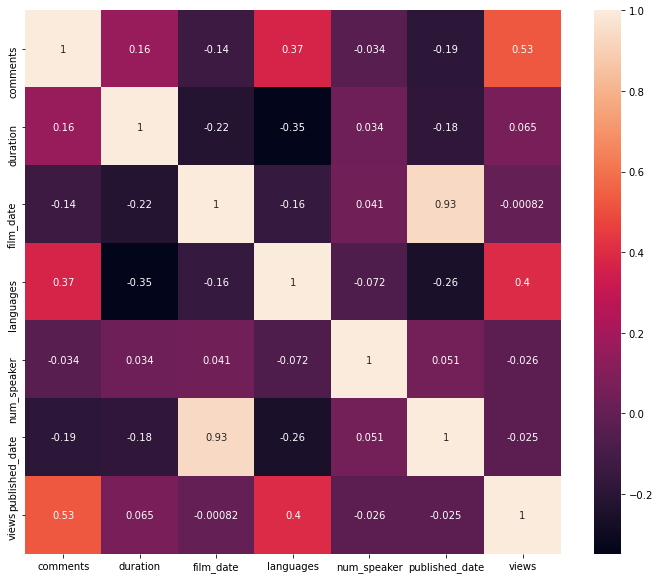

In [98]:
plt.figure(figsize=(12, 10))
sns.heatmap(ted_talk.corr(), annot=True)

In [99]:
profile = ProfileReport(ted_talk)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
transcript_df = ted_talk[['url','transcript']]

In [101]:
transcript_df

url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     Good morning. How are you?(Laughter)It's been ...  
1     Thank you so much, Chris. And it's truly a gre...  
2     (Music: "The Sound of Silence," Simon & Garfun...  
3     If you're here today — and I'm very happy that...  
4     About 10 years ago, I took on the task to teac...  
...                                                 ...  
2462  So, Ma was trying to explain something to me a...  
2463  This is a picture of a sunset on Mars taken by...  
2464  In my early days as a graduate student, I went...  
2465  I took a cell phone and accidentally made myse...  
2466  We humans are becoming an urban species, so ci...  

[2467 rows x 2 columns]

## Text Preporcessing

In [102]:
def toLowerCase(df, colName):
    df[colName] = df[colName].str.lower()
    return df

In [103]:
transcript_df = toLowerCase(transcript_df, 'transcript')
transcript_df

<ipython-input-102-1cfc27e4d39b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].str.lower()


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning. how are you?(laughter)it's been ...  
1     thank you so much, chris. and it's truly a gre...  
2     (music: "the sound of silence," simon & garfun...  
3     if you're here today — and i'm very happy that...  
4     about 10 years ago, i took on the task to teac...  
...                                                 ...  
2462  so, ma was trying to explain something to me a...  
2463  this is a picture of a sunset on mars taken by...  
2464  in my early days as a graduate student, i went...  
2465  i took a cell phone and accidentally made myse...  
2466  we humans are becoming an urban species, so ci...  

[2467 rows x 2 columns]

In [104]:
def removeNotes(df, colName):
    def removed(text):
        s = re.sub("[\(\[].*?[\)\]]", ' ', text)
        return s
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [105]:
transcript_df = removeNotes(transcript_df, 'transcript')
transcript_df

<ipython-input-104-dfa742a0e9e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].apply(lambda text: removed(text))


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning. how are you? it's been great, ha...  
1     thank you so much, chris. and it's truly a gre...  
2      hello voice mail, my old friend. i've called ...  
3     if you're here today — and i'm very happy that...  
4     about 10 years ago, i took on the task to teac...  
...                                                 ...  
2462  so, ma was trying to explain something to me a...  
2463  this is a picture of a sunset on mars taken by...  
2464  in my early days as a graduate student, i went...  
2465  i took a cell phone and accidentally made myse...  
2466  we humans are becoming an urban species, so ci...  

[2467 rows x 2 columns]

In [106]:
def removePunctuation(df, colName):
    def removed(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [107]:
transcript_df = removePunctuation(transcript_df, 'transcript')
transcript_df

<ipython-input-106-d24de4230a1a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].apply(lambda text: removed(text))


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning how are you its been great hasnt ...  
1     thank you so much chris and its truly a great ...  
2      hello voice mail my old friend ive called for...  
3     if youre here today — and im very happy that y...  
4     about 10 years ago i took on the task to teach...  
...                                                 ...  
2462  so ma was trying to explain something to me ab...  
2463  this is a picture of a sunset on mars taken by...  
2464  in my early days as a graduate student i went ...  
2465  i took a cell phone and accidentally made myse...  
2466  we humans are becoming an urban species so cit...  

[2467 rows x 2 columns]

In [108]:
def removeStopwords(df, colName):
    STOPWORDS = set(stopwords.words('english'))
    def removed(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [109]:
transcript_df = removeStopwords(transcript_df, 'transcript')
transcript_df

<ipython-input-108-cbfdc03de179>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].apply(lambda text: removed(text))


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning great hasnt ive blown away whole ...  
1     thank much chris truly great honor opportunity...  
2     hello voice mail old friend ive called tech su...  
3     youre today — im happy — youve heard sustainab...  
4     10 years ago took task teach global developmen...  
...                                                 ...  
2462  trying explain something grandma grew couldnt ...  
2463  picture sunset mars taken nasas curiosity rove...  
2464  early days graduate student went snorkeling tr...  
2465  took cell phone accidentally made famous talki...  
2466  humans becoming urban species cities natural h...  

[2467 rows x 2 columns]

In [110]:
def removeFreqwords(df, colName):
    cnt = Counter()
    for text in df["transcript"].values:
        for word in text.split():
            cnt[word] += 1    
    cnt.most_common(10)
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    def removed(text):
        return " ".join([word for word in str(text).split() if word not in FREQWORDS])
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [111]:
transcript_df = removeFreqwords(transcript_df, 'transcript')
transcript_df

<ipython-input-110-f0cb5215ea00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].apply(lambda text: removed(text))


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning great hasnt ive blown away whole ...  
1     thank much chris truly great honor opportunity...  
2     hello voice mail old friend ive called tech su...  
3     youre today im happy youve heard sustainable d...  
4     10 years ago took task teach global developmen...  
...                                                 ...  
2462  trying explain something grandma grew couldnt ...  
2463  picture sunset mars taken nasas curiosity rove...  
2464  early days graduate student went snorkeling tr...  
2465  took cell phone accidentally made famous talki...  
2466  humans becoming urban species cities natural h...  

[2467 rows x 2 columns]

In [112]:
def removeRarewords(df, colName):
    cnt = Counter()
    for text in df["transcript"].values:
        for word in text.split():
            cnt[word] += 1    
    cnt.most_common(10)
    n_rare_words = 10
    RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    def removed(text):
        return " ".join([word for word in str(text).split() if word not in RAREWORDS])
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [113]:
transcript_df = removeRarewords(transcript_df, 'transcript')
transcript_df

<ipython-input-112-f8511032a079>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].apply(lambda text: removed(text))


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning great hasnt ive blown away whole ...  
1     thank much chris truly great honor opportunity...  
2     hello voice mail old friend ive called tech su...  
3     youre today im happy youve heard sustainable d...  
4     10 years ago took task teach global developmen...  
...                                                 ...  
2462  trying explain something grandma grew couldnt ...  
2463  picture sunset mars taken nasas curiosity rove...  
2464  early days graduate student went snorkeling tr...  
2465  took cell phone accidentally made famous talki...  
2466  humans becoming urban species cities natural h...  

[2467 rows x 2 columns]

In [114]:
def stemWords(df, colName):
    stemmer = PorterStemmer()
    def removed(text):
        return " ".join([stemmer.stem(word) for word in text.split()])
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [115]:
def lemmatize_words(df,colName):
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(text):
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    df[colName] = df[colName].apply(lambda text: lemmatize_words(text))
    return df

In [116]:
transcript_df = lemmatize_words(transcript_df, 'transcript')
transcript_df

<ipython-input-115-cae7e734d70a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName] = df[colName].apply(lambda text: lemmatize_words(text))


url  \
0     https://www.ted.com/talks/ken_robinson_says_sc...   
1     https://www.ted.com/talks/al_gore_on_averting_...   
2     https://www.ted.com/talks/david_pogue_says_sim...   
3     https://www.ted.com/talks/majora_carter_s_tale...   
4     https://www.ted.com/talks/hans_rosling_shows_t...   
...                                                 ...   
2462  https://www.ted.com/talks/duarte_geraldino_wha...   
2463  https://www.ted.com/talks/armando_azua_bustos_...   
2464  https://www.ted.com/talks/radhika_nagpal_what_...   
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...   
2466  https://www.ted.com/talks/karoliina_korppoo_ho...   

                                             transcript  
0     good morning great hasnt ive blown away whole ...  
1     thank much chris truly great honor opportunity...  
2     hello voice mail old friend ive called tech su...  
3     youre today im happy youve heard sustainable d...  
4     10 year ago took task teach global development...  
...                                                 ...  
2462  trying explain something grandma grew couldnt ...  
2463  picture sunset mar taken nasa curiosity rover ...  
2464  early day graduate student went snorkeling tri...  
2465  took cell phone accidentally made famous talki...  
2466  human becoming urban specie city natural habit...  

[2467 rows x 2 columns]

In [117]:
ted_talk = ted_talk.merge(transcript_df, left_on='url', right_on='url')
ted_talk

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2468        17  Between 2008 and 2016, the United States depor...       476   
2469         6  How can you study Mars without a spaceship? He...       290   
2470        10  Science fiction visions of the future show us ...       651   
2471        32  In an unmissable talk about race and politics ...      1100   
2472         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2468       TED2017  1496707200          4     Duarte Geraldino   
2469       TED2017  1492992000          3  Armando Azua-Bustos   
2470       TED2017  1492992000          1       Radhika Nagpal   
2471  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2472       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2468  Duarte Geraldino: What we're missing in the de...            1   
2469  Armando Azua-Bustos: The most Martian place on...            1   
2470  Radhika Nagpal: What intelligent machines can ...            1   
2471  Theo E.J. Wilson: A black man goes undercover ...            1   
2472  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2468      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2469      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2470      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2471      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2472      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2468  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2469  [{'id': 2491, 'hero'

In [118]:
ted_talk.drop('transcript_x',axis='columns', inplace=True)
ted_talk

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2468        17  Between 2008 and 2016, the United States depor...       476   
2469         6  How can you study Mars without a spaceship? He...       290   
2470        10  Science fiction visions of the future show us ...       651   
2471        32  In an unmissable talk about race and politics ...      1100   
2472         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2468       TED2017  1496707200          4     Duarte Geraldino   
2469       TED2017  1492992000          3  Armando Azua-Bustos   
2470       TED2017  1492992000          1       Radhika Nagpal   
2471  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2472       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2468  Duarte Geraldino: What we're missing in the de...            1   
2469  Armando Azua-Bustos: The most Martian place on...            1   
2470  Radhika Nagpal: What intelligent machines can ...            1   
2471  Theo E.J. Wilson: A black man goes undercover ...            1   
2472  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2468      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2469      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2470      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2471      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2472      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2468  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2469  [{'id': 2491, 'hero'

In [119]:
ted_talk.rename(columns = {'transcript_y': 'transcript'}, inplace = True)
ted_talk

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2468        17  Between 2008 and 2016, the United States depor...       476   
2469         6  How can you study Mars without a spaceship? He...       290   
2470        10  Science fiction visions of the future show us ...       651   
2471        32  In an unmissable talk about race and politics ...      1100   
2472         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2468       TED2017  1496707200          4     Duarte Geraldino   
2469       TED2017  1492992000          3  Armando Azua-Bustos   
2470       TED2017  1492992000          1       Radhika Nagpal   
2471  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2472       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2468  Duarte Geraldino: What we're missing in the de...            1   
2469  Armando Azua-Bustos: The most Martian place on...            1   
2470  Radhika Nagpal: What intelligent machines can ...            1   
2471  Theo E.J. Wilson: A black man goes undercover ...            1   
2472  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2468      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2469      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2470      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2471      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2472      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2468  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2469  [{'id': 2491, 'hero'

In [120]:
def correctSpellings(df, colName):
    spell = SpellChecker()
    def removed(text):
        corrected_text = []
        misspelled_words = spell.unknown(text.split())
        for word in text.split():
            if word in misspelled_words:
                corrected_text.append(spell.correction(word))
            else:
                corrected_text.append(word)
        return " ".join(corrected_text)
    df[colName] = df[colName].apply(lambda text: removed(text))
    return df

In [121]:
'''from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])'''

"from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer\nfrom sklearn.feature_extraction.text import TfidfTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.naive_bayes import MultinomialNB\n\nnb = Pipeline([('vect', CountVectorizer()),\n               ('tfidf', TfidfTransformer()),\n               ('clf', MultinomialNB()),\n              ])"

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
                        min_df = 0.05,     # cut words present in less than 5% of documents
                        max_df = 0.3)      # cut words present in more than 30% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(ted_talk['transcript'])
print("done in %0.3fs." % (time() - t0))

done in 1.289s.


## Topic Modelling

### LDA Model

/Users/hayataldhahri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


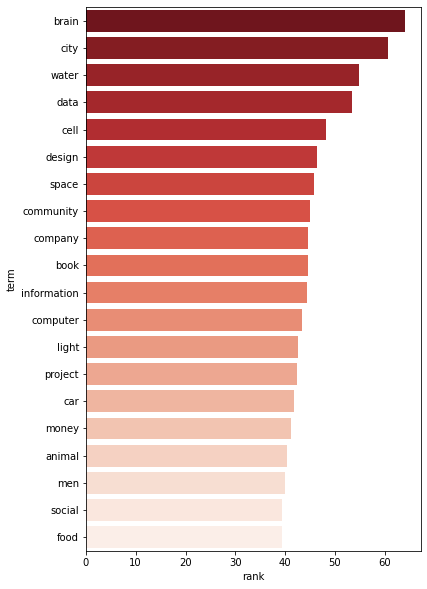

In [123]:
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

In [124]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

topics = lda.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

/Users/hayataldhahri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['economist', 'sustainable', 'survey', 'financial', 'investment'],
 1: ['brain', 'music', 'robot', 'sound', 'play'],
 2: ['la', 'sorry', 'oh', 'welcome', 'chose'],
 3: ['economist', 'sustainable', 'survey', 'financial', 'investment'],
 4: ['economist', 'sustainable', 'survey', 'financial', 'investment'],
 5: ['city', 'water', 'data', 'community', 'company'],
 6: ['economist', 'sustainable', 'survey', 'financial', 'investment'],
 7: ['economist', 'sustainable', 'survey', 'financial', 'investment'],
 8: ['economist', 'sustainable', 'survey', 'financial', 'investment'],
 9: ['web', 'internet', 'link', 'page', 'government']}

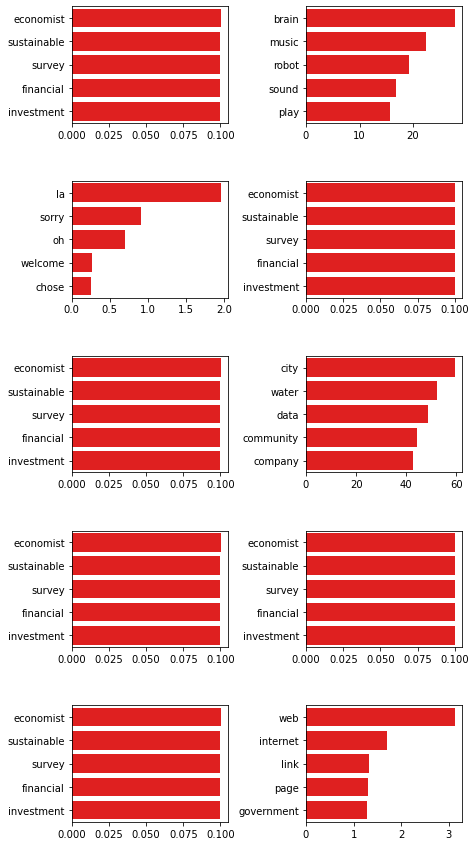

In [125]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

Our objective for the NLP to extract and categorize the ideas and thoughts in the transcripts into specific topics. we started using **LDA** with ‘tfidf’ for the model. The results from the **LDA model** show that there are words that are not related to each other and repeated words.

To optimize the model, we will be using **NMF**

 ### NMF Model

In [126]:
from sklearn.decomposition import NMF

n_topics = 10
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

/Users/hayataldhahri/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/hayataldhahri/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/hayataldhahri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['girl', 'men', 'mother', 'father', 'god'],
 1: ['cell', 'dna', 'gene', 'molecule', 'cancer'],
 2: ['water', 'ocean', 'animal', 'fish', 'plant'],
 3: ['patient', 'cancer', 'disease', 'health', 'doctor'],
 4: ['computer', 'data', 'design', 'information', 'machine'],
 5: ['city', 'car', 'design', 'space', 'street'],
 6: ['brain', 'memory', 'animal', 'behavior', 'activity'],
 7: ['robot', 'machine', 'leg', 'animal', 'intelligence'],
 8: ['universe', 'planet', 'earth', 'star', 'space'],
 9: ['government', 'company', 'money', 'dollar', 'business']}

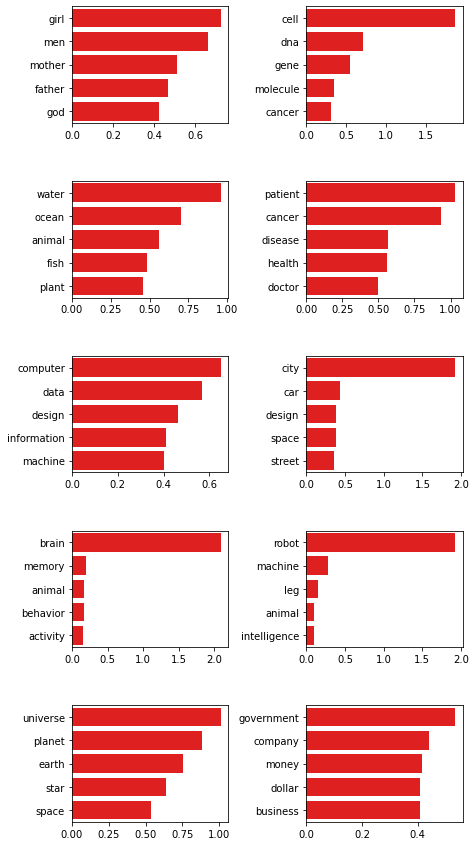

In [127]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [128]:
# Formulating a pipeline to insert a document and extract the topics pertinency
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

document_id = 4
t = pipe.transform([ted_talk['transcript'].iloc[document_id]]) 
print('Topic distribution for document #{}: \n'.format(document_id),t)
print('Relevant topics for document #{}: \n'.format(document_id),np.where(t>0.01)[1])
print('\nTranscript:\n',ted_talk['transcript'].iloc[document_id][:500],'...')

talk = ted_talk[ted_talk['url']==transcripts['url'].iloc[document_id]]
print('\nTrue tags from ted_main.csv: \n',talk['tags'])

Topic distribution for document #4: 
 [[0.         0.         0.00258301 0.04560485 0.05645818 0.
  0.         0.         0.         0.15023335]]
Relevant topics for document #4: 
 [3 4 9]

Transcript:
 10 year ago took task teach global development swedish undergraduate student spent 20 year together african institution studying hunger africa sort expected little world started medical university karolinska institute undergraduate course called global health get opportunity get little nervous thought student coming u actually highest grade get swedish college system thought maybe everything im teach pretest came question learned lot country highest child mortality five pairsi put together pair  ...

True tags from ted_main.csv: 
 4    ['Africa', 'Asia', 'Google', 'demo', 'economic...
Name: tags, dtype: object


In [129]:
t = pipe.transform(ted_talk['transcript']) 
t = pd.DataFrame(t, columns=[str(t_words[i]) for i in range(0,10)])
t

['girl', 'men', 'mother', 'father', 'god']  \
0                                       0.108157   
1                                       0.025988   
2                                       0.024966   
3                                       0.022837   
4                                       0.000000   
...                                          ...   
2468                                    0.043054   
2469                                    0.000000   
2470                                    0.000000   
2471                                    0.057523   
2472                                    0.000000   

      ['cell', 'dna', 'gene', 'molecule', 'cancer']  \
0                                          0.000000   
1                                          0.000000   
2                                          0.011771   
3                                          0.000000   
4                                          0.000000   
...                                             ...   
2468                                       0.000000   
2469                                       0.000000   
2470                                       0.002167   
2471                                       0.024148   
2472                                       0.000000   

      ['water', 'ocean', 'animal', 'fish', 'plant']  \
0                                          0.000000   
1                                          0.037767   
2                                          0.000000   
3                                          0.045919   
4                                          0.002582   
...                                             ...   
2468                                       0.000000   
2469                                       0.102235   
2470                                       0.011626   
2471                                       0.004829   
2472                                       0.000000   

      ['patient', 'cancer', 'disease', 'health', 'doctor']  \
0                                              0.000000      
1                                              0.000000      
2                                              0.000000      
3                                              0.010353      
4                                              0.045605      
...                                                 ...      
2468                                           0.000000      
2469                                           0.000000      
2470                                           0.000000      
2471                                           0.000000      
2472                                           0.000000      

      ['computer', 'data', 'design', 'information', 'machine']  \
0                                              0.017325          
1                                              0.022898          
2                                              0.136291          
3                                              0.000000          
4                                              0.056459          
...                                                 ...          
2468                                           0.000000          
2469                                           0.000000          
2470                                           0.000000          
2471                                           0.060908          
2472                                           0.003498          

      ['city', 'car', 'design', 'space', 'street']  \
0                                         0.000000   
1                                         0.038399   
2                                         0.000000   
3                                         0.162501   
4                                         0.000000   
...                                            ...   
2468                                      0.021149   
2469                                      0.000000   
2470                               

Reflect the Topic labels in the data frame.  

In [137]:
t.rename(columns = {'[\'girl\', \'men\', \'mother\', \'father\', \'god\']':'Family','[\'cell\', \'dna\', \'gene\', \'molecule\', \'cancer\']':'Genetics','[\'water\', \'ocean\', \'animal\', \'fish\', \'plant\']':'Nature','[\'patient\', \'cancer\', \'disease\', \'health\', \'doctor\']':'Health','[\'computer\', \'data\', \'design\', \'information\', \'machine\']':'Technology','[\'city\', \'car\', \'design\', \'space\', \'street\']':'Cival','[\'brain\', \'memory\', \'animal\', \'behavior\', \'activity\']':'Biology','[\'robot\', \'machine\', \'leg\', \'animal\', \'intelligence\']':'Robotics','[\'universe\', \'planet\', \'earth\', \'star\', \'space\']':'Space','[\'government\', \'company\', \'money\', \'dollar\', \'business\']':'Goverment'}, inplace = True)
t

Family  Genetics    Nature    Health  Technology     Cival   Biology  \
0     0.108157  0.000000  0.000000  0.000000    0.017325  0.000000  0.020915   
1     0.025988  0.000000  0.037767  0.000000    0.022898  0.038399  0.000000   
2     0.024966  0.011771  0.000000  0.000000    0.136291  0.000000  0.000000   
3     0.022837  0.000000  0.045919  0.010353    0.000000  0.162501  0.000000   
4     0.000000  0.000000  0.002582  0.045605    0.056459  0.000000  0.000000   
...        ...       ...       ...       ...         ...       ...       ...   
2468  0.043054  0.000000  0.000000  0.000000    0.000000  0.021149  0.005665   
2469  0.000000  0.000000  0.102235  0.000000    0.000000  0.000000  0.000000   
2470  0.000000  0.002167  0.011626  0.000000    0.000000  0.000000  0.001497   
2471  0.057523  0.024148  0.004829  0.000000    0.060908  0.004436  0.002397   
2472  0.000000  0.000000  0.000000  0.000000    0.003498  0.280101  0.004832   

      Robotics     Space  Goverment  
0     0.000000  0.017562   0.005775  
1     0.000000  0.011147   0.088861  
2     0.000000  0.000000   0.028782  
3     0.000000  0.000000   0.080605  
4     0.000000  0.000000   0.150233  
...        ...       ...        ...  
2468  0.000000  0.000000   0.064345  
2469  0.022530  0.100210   0.000000  
2470  0.324508  0.006119   0.004836  
2471  0.000000  0.030873   0.030088  
2472  0.000000  0.000000   0.000000  

[2473 rows x 10 columns]

<Figure size 864x432 with 0 Axes>

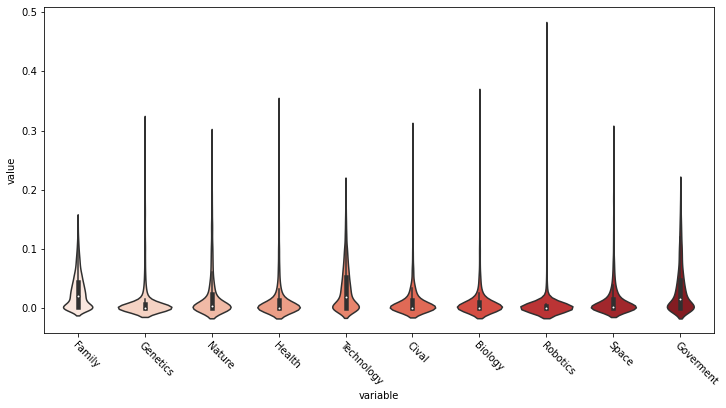

In [138]:
%matplotlib inline
new_t = t.melt()

fig = plt.figure(1,figsize=(12,6))
fig, ax = plt.subplots(figsize=(12,6), ncols=1, nrows=1)
sns.violinplot(x="variable", y="value", data=new_t, palette='Reds', ax=ax)
plt.xticks(rotation=75)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor");

In [139]:
topics.shape

(2473, 10)

In [134]:
ted_talk['Topic'] = topics.argmax(axis=1)
ted_talk

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2468        17  Between 2008 and 2016, the United States depor...       476   
2469         6  How can you study Mars without a spaceship? He...       290   
2470        10  Science fiction visions of the future show us ...       651   
2471        32  In an unmissable talk about race and politics ...      1100   
2472         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2468       TED2017  1496707200          4     Duarte Geraldino   
2469       TED2017  1492992000          3  Armando Azua-Bustos   
2470       TED2017  1492992000          1       Radhika Nagpal   
2471  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2472       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2468  Duarte Geraldino: What we're missing in the de...            1   
2469  Armando Azua-Bustos: The most Martian place on...            1   
2470  Radhika Nagpal: What intelligent machines can ...            1   
2471  Theo E.J. Wilson: A black man goes undercover ...            1   
2472  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2468      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2469      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2470      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2471      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2472      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2468  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2469  [{'id': 2491, 'hero'

In [140]:
ted_talk.loc[ted_talk.Topic == 0, "Topic"] = "Family"
ted_talk.loc[ted_talk.Topic == 1, "Topic"] = "Genetics"
ted_talk.loc[ted_talk.Topic == 2, "Topic"] = "Nature"
ted_talk.loc[ted_talk.Topic == 3, "Topic"] = "Health"
ted_talk.loc[ted_talk.Topic == 4, "Topic"] = "Technology"
ted_talk.loc[ted_talk.Topic == 5, "Topic"] = "Cival"
ted_talk.loc[ted_talk.Topic == 6, "Topic"] = "Biology"
ted_talk.loc[ted_talk.Topic == 7, "Topic"] = "Robotics"
ted_talk.loc[ted_talk.Topic == 8, "Topic"] = "Space"
ted_talk.loc[ted_talk.Topic == 9, "Topic"] = "Goverment"

ted_talk

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2468        17  Between 2008 and 2016, the United States depor...       476   
2469         6  How can you study Mars without a spaceship? He...       290   
2470        10  Science fiction visions of the future show us ...       651   
2471        32  In an unmissable talk about race and politics ...      1100   
2472         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2468       TED2017  1496707200          4     Duarte Geraldino   
2469       TED2017  1492992000          3  Armando Azua-Bustos   
2470       TED2017  1492992000          1       Radhika Nagpal   
2471  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2472       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2468  Duarte Geraldino: What we're missing in the de...            1   
2469  Armando Azua-Bustos: The most Martian place on...            1   
2470  Radhika Nagpal: What intelligent machines can ...            1   
2471  Theo E.J. Wilson: A black man goes undercover ...            1   
2472  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2468      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2469      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2470      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2471      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2472      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2468  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2469  [{'id': 2491, 'hero'

### Creating Word Cloud

In [141]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [142]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [143]:
topic_cloud = ' '.join(ted_talk['Topic'])

In [144]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(topic_cloud)

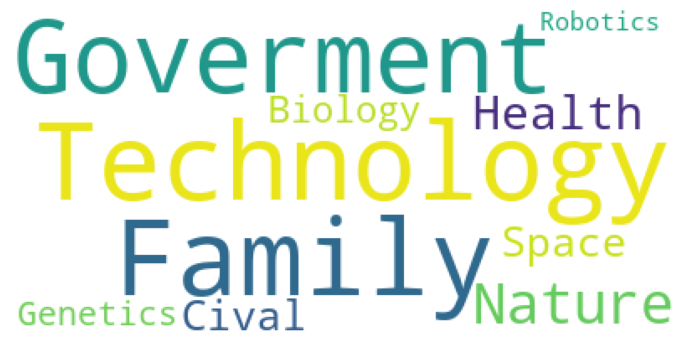

In [145]:
plt.figure(figsize=(12,15))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [146]:
t2=' '.join(ted_talk['transcript'])

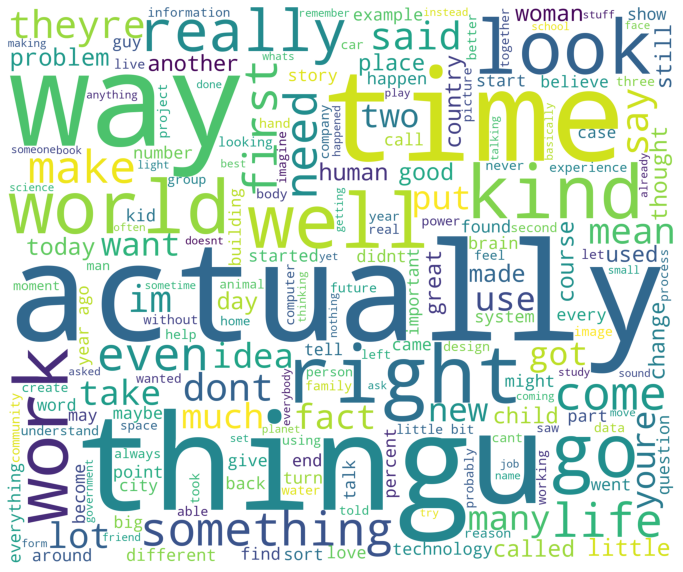

In [147]:
wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color='white',width=2400,height=2000).generate(t2)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()


In [148]:
ted_talk2=ted_talk[['Topic','views']]
ted_talk2.to_csv('ted_talk2.csv')